# Can we predict how long a submitted job will sit in the queue? (And what the most important characteristics of a job are that make it sit in the queue?) 

- Response: Queue time = Start – Submit 

- Predictors:  cpu, memory, node (billing?) 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [15]:
slurm = pd.read_csv("/mnt/research/CMSE495-SS24-ICER/slurm_usage/DID_FINAL_SLURM_OCT_2023.csv",delimiter="|", nrows=100000)

# data preprocessing
slurm = slurm.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# # Filter out rows where 'State' is "Cancelled" or Unknown
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])

In [16]:
# remove user_258 and clean jobs data
def AggSLURMDat(dat):
    '''
    Aggregates all submitted jobs together, removing all batch/extern 
    jobs and including said information into a single job. Excludes
    jobs that do not have a clear '.batch' and '.extern' files

    args:

        dat - the slurm dataset 
    
    returns:

        out_df - the aggregated version of the slurm dataset
    '''
    
    job_list = dat["JobID"].value_counts().index

    out_df = pd.DataFrame(columns=dat.keys())

    for job in job_list:

        jdat = dat[dat["JobID"] == job]

        cpu_time_list = jdat["CPUTimeRAW"].value_counts()
        cpu_time_list = cpu_time_list[cpu_time_list == 2].index

        for cpu_time in cpu_time_list:

            ajob = jdat[jdat["CPUTimeRAW"] == cpu_time]

            batch_job = ajob[ajob["User"] == "user_258"]

            ag_job = ajob[ajob["User"] != "user_258"]

            if len(ag_job["User"]) == 0:
#                 print("Weird Job",ajob["JobID"])
#                 print("No aggregate job")
                continue
            
            if len(ag_job["User"]) == 2:
#                 print("Weird Job",ajob["JobID"])
#                 print("2 copies of aggregate job")
                continue

            assert len(ag_job["User"]) == 1, "New edge case discovered!"

            ag_job.loc[ag_job.index[0],"MaxRSS"] = batch_job["MaxRSS"].values[0]

            out_df = pd.concat([out_df,ag_job])

    return out_df
slurm_clean = AggSLURMDat(slurm)

In [17]:
# remove na rows in MaxRSS after cleaning data
slurm_clean= slurm_clean.dropna(subset=['MaxRSS'])

In [18]:
# # convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    
slurm_clean['ReqMem_MB'] = slurm_clean['ReqMem'].apply(convert_memory)
slurm_clean['MaxRSS_MB'] = slurm_clean['MaxRSS'].apply(convert_memory)

In [21]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm_clean['Timelimit'] = slurm_clean['Timelimit'].apply(parse_time_string)
slurm_clean['Elapsed'] = slurm_clean['Elapsed'].apply(parse_time_string)

In [27]:
slurm_clean.head()

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB
75766,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:11:08,0 days 00:02:38,COMPLETED,account_017,assocID_554,...,1,10G,348380K,1,1,lac-351,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,348.380
75880,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:09:18,0 days 00:00:48,FAILED,account_017,assocID_554,...,1,10G,8156K,1,1,lac-367,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,8.156
77026,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:10:33,0 days 00:02:02,FAILED,account_017,assocID_554,...,1,10G,344968K,1,1,lac-295,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,344.968
77281,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:11:31,0 days 00:03:00,COMPLETED,account_017,assocID_554,...,1,10G,489700K,1,1,lac-299,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,489.700
76963,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:09:36,0 days 00:01:05,FAILED,account_017,assocID_554,...,1,10G,270400K,1,1,lac-294,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,270.400


In [59]:
# Calculate queutime in minutes
slurm_clean["QueueTime (Minutes)"] = (slurm_clean['Start']- slurm_clean['Submit']).dt.total_seconds()/60
slurm_clean['Timelimit (Minutes)'] = slurm_clean['Timelimit'].dt.total_seconds()/60
slurm_clean.head(5)

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,QueueTime,QueueTime (Minutes),Timelimit (Minutes)
75766,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:11:08,0 days 00:02:38,COMPLETED,account_017,assocID_554,...,1,1,lac-351,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,348.380,26.0,0.433333,19.0
75880,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:09:18,0 days 00:00:48,FAILED,account_017,assocID_554,...,1,1,lac-367,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,8.156,26.0,0.433333,19.0
77026,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:10:33,0 days 00:02:02,FAILED,account_017,assocID_554,...,1,1,lac-295,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,344.968,27.0,0.450000,19.0
77281,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:11:31,0 days 00:03:00,COMPLETED,account_017,assocID_554,...,1,1,lac-299,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,489.700,27.0,0.450000,19.0
76963,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:09:36,0 days 00:01:05,FAILED,account_017,assocID_554,...,1,1,lac-294,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,270.400,27.0,0.450000,19.0


In [60]:
slurm_clean.columns

Index(['JobID', 'User', 'Group', 'Submit', 'Start', 'End', 'Elapsed', 'State',
       'Account', 'AssocID', 'Partition', 'Timelimit', 'UserCPU', 'SystemCPU',
       'TotalCPU', 'CPUTime', 'CPUTimeRAW', 'ReqCPUS', 'AllocCPUS', 'ReqMem',
       'MaxRSS', 'ReqNodes', 'NNodes', 'NodeList', 'ReqTRES', 'AllocTRES',
       'ReqMem_MB', 'MaxRSS_MB', 'QueueTime', 'QueueTime (Minutes)',
       'Timelimit (Minutes)'],
      dtype='object')

/mnt/home/alkhali7/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


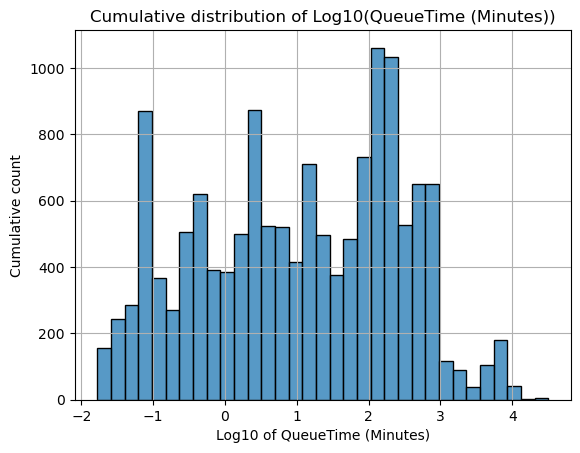

In [51]:
sns.histplot(np.log10(slurm_clean['QueueTime (Minutes)']))
plt.xlabel('Log10 of QueueTime (Minutes)')
plt.ylabel('Cumulative count')
plt.title('Cumulative distribution of Log10(QueueTime (Minutes))')
plt.grid(True) 
plt.show()

# Predictive modeling

**Random Forest Model**

In [62]:
# prepare the dataset for training
X = slurm_clean[['ReqCPUS','ReqMem_MB','ReqNodes','Timelimit (Minutes)']]
y = slurm_clean['QueueTime (Minutes)']

# splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

# standarize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a random Forest Regressor 
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = model.predict(X_test_scaled)

# evaluate the model; do R2 
print("Mean Absolute Error", mean_absolute_error(y_test,y_pred))

Mean Absolute Error 104.67038794283958


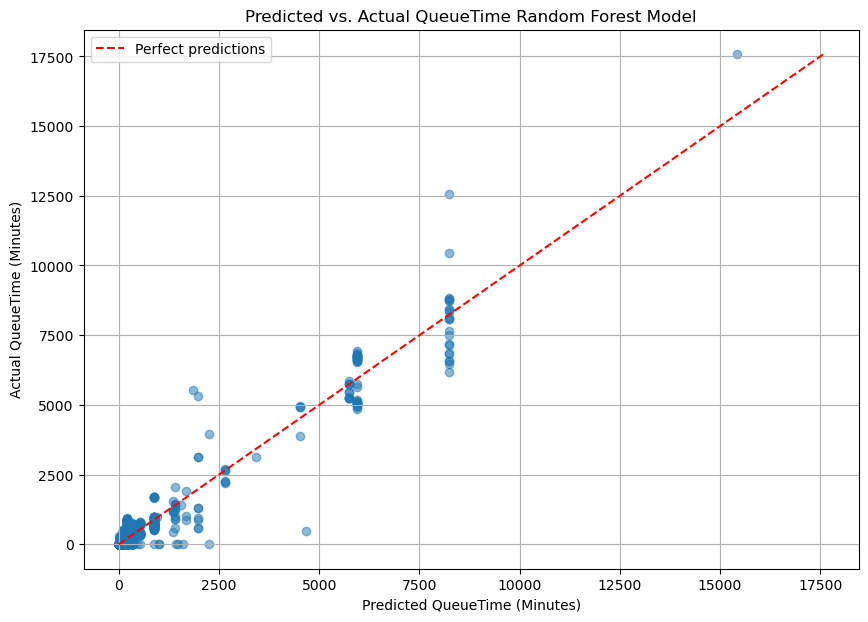

In [67]:
# Plotting both the identity line (for reference) and the scatter plot
plt.figure(figsize=(10, 7))  # Optional: you can adjust the figure size as needed

# Identity line for reference (where perfect predictions would lie)
array = np.arange(0, np.max([y_test.max(), y_pred.max()])+1)  # Adjust the range based on your data
plt.plot(array, array, 'r--', label='Perfect predictions')  # Red dashed line for reference

# Scatter plot of Predicted vs. Actual values
plt.scatter(y_pred, y_test, alpha=0.5)  # Alpha for marker opacity

# Adding title and axis labels
plt.title('Predicted vs. Actual QueueTime Random Forest Model')
plt.xlabel('Predicted QueueTime (Minutes)')
plt.ylabel('Actual QueueTime (Minutes)')

# Adding a legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()